In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
import natsort
from openpyxl import load_workbook
import random
from random import randrange
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Keras
import keras

from keras import models
from keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


IMPORT MODEL AND DATA

In [2]:
#load certain model
model = load_model('./for_old23/standard_MFCC_Dense_Classifier_l-3_u-2048_e-1000_1588149488.h5')

In [3]:
#read training dataset from csv
#music
data6_10 = pd.read_csv('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/Mel_scale/data6_10ms.csv')
data6_50 = pd.read_csv('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/Mel_scale/data6_50ms.csv')
data6_100 = pd.read_csv('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/Mel_scale/data6_100ms.csv')
data6_500 = pd.read_csv('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/Mel_scale/data6_500ms.csv')
data6_1000 = pd.read_csv('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/Mel_scale/data6_1000ms.csv')

#speech
data5_10 = pd.read_csv('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/Mel_scale/data5_10ms.csv')
data5_50 = pd.read_csv('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/Mel_scale/data5_50ms.csv')
data5_100 = pd.read_csv('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/Mel_scale/data5_100ms.csv')
data5_500 = pd.read_csv('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/Mel_scale/data5_500ms.csv')
data5_1000 = pd.read_csv('D:/Users/MC/Documents/UNI/MASTER/thesis/MFCC_FEATURES2/Mel_scale/data5_1000ms.csv')

#join
data = pd.concat([data6_10, data6_50, data6_100, data6_500, data6_1000, data5_10, data5_50, data5_100, data5_500, data5_1000])

In [4]:
#randomly display some of the data
data_subset = data.sample(n=5)
data_subset.head()

,filename,mfccM0,mfccV0,mfccM1,mfccV1,mfccM2,mfccV2,mfccM3,mfccV3,mfccM4,...,deltaDeltaV35,deltaDeltaM36,deltaDeltaV36,deltaDeltaM37,deltaDeltaV37,deltaDeltaM38,deltaDeltaV38,deltaDeltaM39,deltaDeltaV39,label
16932,342_h_10_music-jamendo-0029.wav,-169.775085,555.008911,133.027802,241.414078,-4.970676,153.451385,9.181425,69.996841,28.980265,...,0.027183,-0.002522,0.028524,-0.001701,0.022666,0.000455,0.023032,0.002128,0.025753,342
7062,99_h_100_5266-41151-0054.wav,-242.345520,3649.080566,95.645966,1333.521729,-3.840138,445.764648,11.018790,205.020050,7.884940,...,0.028131,0.000931,0.028442,0.001528,0.025057,0.000811,0.031098,-0.000075,0.030188,99
3926,72_h_500_music-rfm-0098.wav,-134.667114,497.530518,108.703903,107.880554,-25.583555,124.389793,30.079384,48.321926,3.471675,...,0.030038,0.001503,0.029452,-0.000109,0.032022,-0.001055,0.032597,0.000705,0.031321,72
17552,252_h_10_663-128991-0005.wav,-238.314621,1760.253296,76.494087,873.782349,14.529278,571.860596,27.836246,315.613037,19.149658,...,0.032548,-0.001465,0.035657,-0.001189,0.032831,-0.000820,0.038288,-0.000002,0.027683,252
19395,279_h_500_6865-95969-0018.wav,-177.917648,4648.828125,95.905708,874.079773,-33.512573,465.694366,31.262833,465.907471,3.454396,...,0.031677,0.001980,0.028140,-0.000181,0.032342,-0.000391,0.032423,-0.001271,0.032949,279


PREPARE DATA FOR EVALUATION

In [5]:
#dropping unneccesary columns and storing filenames elsewhere
fileNames = data['filename']
data = data.drop(['filename'],axis=1)
fileNames.head()

0    0_h_10_music-fma-0001.wav
1    0_h_10_music-fma-0002.wav
2    0_h_10_music-fma-0004.wav
3    0_h_10_music-fma-0005.wav
4    0_h_10_music-fma-0006.wav
Name: filename, dtype: object

In [6]:
#making labels
labels_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(labels_list)
print(y)
print(y.shape)

[ 0  0  0 ... 39 39 39]
(210400,)


In [7]:
# normalizing
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

EVALUATE MODEL ON DATASET

In [8]:
#make prediction for each sample in X and evaluate entire model to get an idea of accuracy
predictions = model.predict(X)
test_loss, test_acc = model.evaluate(X,y)

210400/210400 [==============================] - 95s 453us/sample - loss: 0.4908 - accuracy: 0.8413


EVALUATE MODEL

In [9]:
#method to get difference between elements on circular scale
def absolute_diff(int1,int2):
    m_min = min(int1,int2)
    m_max = max(int1,int2)
    diff1 = m_max-m_min
    diff2 = m_min + 40 - m_max
    return diff1 if diff1 <=20 else diff2

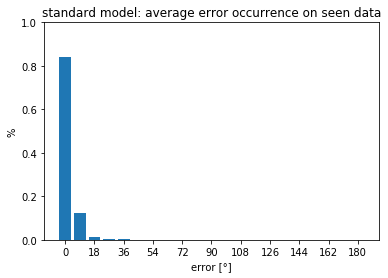

98% of predictions are correct within 45°
99% of predictions are correct within 90°
###########################################################################################


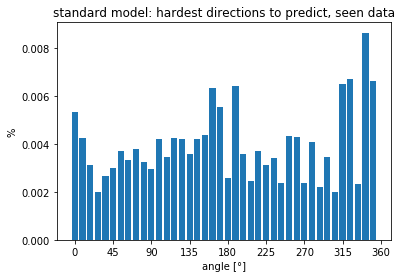

In [10]:
#COMPARE ALL PREDICTIONS TO LABELS AND PLOT BAR GRAPHS
#simple version: only compare most likely prediciont vs label
labels = y
predictions = predictions
#check which errors occur and add 1 to each index
occuring_errors = np.zeros(21)
hardest_to_predict = np.zeros(40)
save_fig_file_path = 'D:/Users/MC/Documents/UNI/MASTER/thesis/SCRIPTURE_FIGURES/H6/std_model_error_seen_data'

for i in range(predictions.shape[0]):
    label = labels[i]
    predicted = np.argmax(predictions[i])
    error = absolute_diff(predicted,label)
    occuring_errors[error] = occuring_errors[error] + 1
    if error != 0:
        hardest_to_predict[label] += 1 
    
x_as = np.array(range(21))
avg_occuring_errors = occuring_errors/(labels.shape[0])
plt.bar(x_as,avg_occuring_errors)
plt.title('standard model: average error occurrence on seen data')
plt.ylabel('%')
plt.ylim([0,1])
plt.xlabel('error [°]')
plt.xticks([ 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], [ 0, 18, 36, 54, 72, 90,  108, 126, 144, 162, 180])
plt.savefig(f'{save_fig_file_path}.png')
plt.show();
error_45 = np.sum(avg_occuring_errors[0:5])
print(f'{int(error_45*100)}% of predictions are correct within 45°')
error_90 = np.sum(avg_occuring_errors[0:10])
print(f'{int(error_90*100)}% of predictions are correct within 90°')
print('###########################################################################################')
x_as = np.array(range(40))
avg_hardest_to_predict = hardest_to_predict/(labels.shape[0])
plt.bar(x_as,avg_hardest_to_predict)
plt.title('standard model: hardest directions to predict, seen data')
plt.ylabel('%')
plt.xlabel('angle [°]')
plt.xticks([0,5,10,15,20,25,30,35,40], [ 0,45,90,135,180,225,270,315,360])
# plt.xticks([ 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26,28,30,32,34,36,38], [ 0, 18, 36, 54, 72, 90,  108, 126, 144, 162, 180,198,216,234,252,270,288,306,324,342])
plt.show();

label:
33
predicted:
33


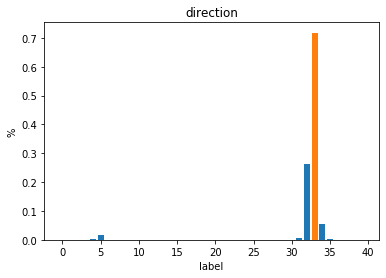

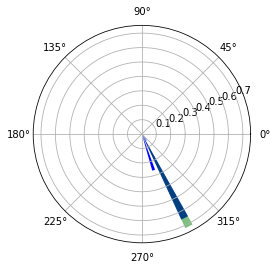

In [16]:
#RANDOMLY SELECT 1 INDEX AND COMPARE THE LABEL VS THE PREDICTION
index = randrange(0,X.shape[0])
label = y[index]
print("label:")
print(label)
print("predicted:")
print(np.argmax(predictions[index]))
#linear bar plot
plt.bar(np.arange(len(predictions[index,:])),predictions[index,:], align='center', alpha=1)
labels = np.zeros((40,))
labels[label] = np.amax(predictions[index]) + 0.1*(np.amax(predictions[index]))
plt.bar(np.arange(len(predictions[index,:])),labels[:], align='center', alpha=1)
plt.ylabel('%')
plt.xlabel('label')
plt.title('direction')
plt.show()
#polar bar plot
N = 40
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
width = np.pi / 40 
ax = plt.subplot(111, projection='polar')
ax.bar(theta, predictions[index,:], width=width, color='b', bottom=0.0, alpha=1)
ax.bar(theta, labels[:], width=width, color='g', bottom=0.0, alpha=0.5)
plt.show()

In [23]:
#method to aggregate predictions: make prediction based on surrounding probabilities
#go around 360° or 40labels
#sum current probabilitye, preivous 2 probabilities and next 2 probabilities to get resolution of 45°
def smart_prediction(predictions):
    be = np.zeros(40)
    for i in range(40):
        #2 back
        index = i-2
        if index < 0:
            index = 40+i-2
        predicted_b2 = predictions[index]
        index = i
        #1 back
        index = i-1
        if index < 0:
            index = 40+i-1
        predicted_b1 = predictions[index]
        index = i
        #current
        predicted = predictions[index]
        #1 forward
        index = i+1
        if index > 39:
            index = 0
        predicted_f1 = predictions[index]
        index = i
        #2 forward
        index = i+2
        if index > 39:
            index = 0+1-(39-i)
        predicted_f2 = predictions[index]
        
        s = (predicted_b2 + predicted_b1 + predicted + predicted_f1 + predicted_f2)
        be[i] = s
    return np.argmax(be)

label: 13 	 predict: 12	 error: 1
label: 3 	 predict: 3
label: 3 	 predict: 2	 error: 1
label: 16 	 predict: 16
label: 2 	 predict: 2
label: 29 	 predict: 29
label: 32 	 predict: 32
label: 2 	 predict: 2
label: 21 	 predict: 21
label: 19 	 predict: 18	 error: 1
label: 32 	 predict: 7	 error: 15
label: 32 	 predict: 7	 error: 15	 smart_predict: 7	 smart_error: 15


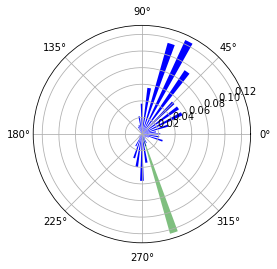

288_h_10_music-fma-wa-0058.wav

label: 23 	 predict: 23
label: 39 	 predict: 39
label: 6 	 predict: 7	 error: 1
label: 19 	 predict: 19
label: 29 	 predict: 29
label: 8 	 predict: 18	 error: 10
label: 8 	 predict: 18	 error: 10	 smart_predict: 18	 smart_error: 10


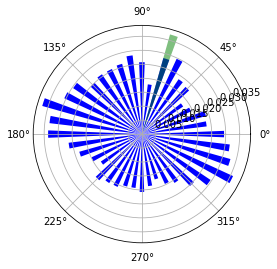

72_h_100_music-jamendo-0071.wav

label: 29 	 predict: 29
label: 16 	 predict: 16
label: 36 	 predict: 37	 error: 1
label: 20 	 predict: 20
label: 5 	 predict: 5
label: 8 	 predict: 8
label: 5 	 predict: 5
label: 6 	 predict: 6
label: 19 	 predict: 19
label: 21 	 predict: 21
label: 15 	 predict: 15
label: 38 	 predict: 38
label: 39 	 predict: 0	 error: 1
label: 36 	 predict: 36
label: 6 	 predict: 6
label: 38 	 predict: 39	 error: 1
label: 5 	 predict: 5
label: 28 	 predict: 28
label: 7 	 predict: 7
label: 17 	 predict: 17
label: 31 	 predict: 31
label: 15 	 predict: 15
label: 38 	 predict: 38
label: 11 	 predict: 11
label: 39 	 predict: 39
label: 25 	 predict: 25
label: 28 	 predict: 28
label: 32 	 predict: 32
label: 10 	 predict: 10
label: 25 	 predict: 25
label: 9 	 predict: 9
label: 14 	 predict: 14
label: 22 	 predict: 22
label: 3 	 predict: 3
label: 13 	 predict: 13
label: 28 	 predict: 28
label: 10 	 predict: 10
label: 6 	 predict: 6
label: 6 	 predict: 6
label: 18 	 predict: 18


In [33]:
#RANDOMLY SELECT A HUNDRED SAMPLES AND PLOT THOSE WHO ARE OF BY MORE THAN 45° AND SAVE THOSE
save_fig_location = 'D:/Users/MC/Documents/UNI/MASTER/thesis/SCRIPTURE_FIGURES/Mel_scale/seen'
counter = 0
randomIndexes = random.sample(range(0,X.shape[0]),100)
allErrors = []
for index in randomIndexes:
    label = y[index]
    predicted = np.argmax(predictions[index])
    output = f'label: {label} \t predict: {predicted}'
    error = absolute_diff(predicted,label)
    error = absolute_diff(predicted,label)
    if error != 0:
        output += f'\t error: {error}'
        allErrors.append(error)
    print(output)
    if error >5:
        smart_pred = smart_prediction(predictions[index])
        output += f'\t smart_predict: {smart_pred}'
        smart_error = absolute_diff(smart_pred,label)
        output += f'\t smart_error: {smart_error}'
        print(output)
        labels = np.zeros((40,))
        labels[label] = np.amax(predictions[index])
        ax = plt.subplot(111, projection='polar')
        ax.bar(theta, predictions[index,:], width=width, color='b', bottom=0.0, alpha=1)
        ax.bar(theta, labels[:], width=width, color='g', bottom=0.0, alpha=0.5)
        plt.savefig(f'{save_fig_location}/{fileNames.iloc[index]}.png')
        plt.show()
        print(fileNames.iloc[index])
        print()
        counter += 1
print(f'{counter} of {len(randomIndexes)} were off by more than 45°')
allErrors = np.array(allErrors)
m_mean = np.round(np.mean(allErrors))
m_max = np.amax(allErrors)
print(f'average error is {m_mean} or {m_mean*9}°')
print(f'max error is {m_max} or {m_max*9}°')